## imports

In [2]:
import sys
import os
sys.path.append(os.path.abspath('..'))  # Append parent directory to Python path

import pandas as pd
from scripts.data_loader import load_data
from scripts.plot_util import PlotHelper
# from scripts.preprocess import preprocess_data



load data basic eda

In [3]:
df = load_data("../data/raw_analyst_ratings.csv")
print(df.head())
print(df.columns)

   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

                        date stock  
0  2020-06-05 10:30:54-04:00     A  
1  2020-06-03 10:45:20-04:00     A  
2  2020-05-26 04:30:07-04:00 

In [4]:
print(df.info())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Unnamed: 0  1407328 non-null  int64 
 1   headline    1407328 non-null  object
 2   url         1407328 non-null  object
 3   publisher   1407328 non-null  object
 4   date        1407328 non-null  object
 5   stock       1407328 non-null  object
dtypes: int64(1), object(5)
memory usage: 64.4+ MB
None
(1407328, 6)


In [5]:
print(type(df['headline']))
print(df['headline'].head())

<class 'pandas.core.series.Series'>
0              Stocks That Hit 52-Week Highs On Friday
1           Stocks That Hit 52-Week Highs On Wednesday
2                        71 Biggest Movers From Friday
3         46 Stocks Moving In Friday's Mid-Day Session
4    B of A Securities Maintains Neutral on Agilent...
Name: headline, dtype: object


In [6]:
# --- 1. Handling Null Values ---

print("\n--- 1. Null Value Check (Before Cleaning) ---")
print(df.isnull().sum())

# We focus on the 'headline' column since it's used for sentiment analysis.
# Strategy: Drop rows where the 'headline' is null, as we can't analyze empty text.
df.dropna(subset=['headline'], inplace=True)
print("\n--- Null Value Check (After Cleaning) ---")
print(f"Remaining rows after dropping null headlines: {df.shape[0]}")


--- 1. Null Value Check (Before Cleaning) ---
Unnamed: 0    0
headline      0
url           0
publisher     0
date          0
stock         0
dtype: int64

--- Null Value Check (After Cleaning) ---
Remaining rows after dropping null headlines: 1407328


In [7]:
# --- 2. Date Structure and Time Series Preparation  ---

if 'date' in df.columns:
    
    # 1. Force conversion using 'ISO8601' format and ensure UTC conversion.
    # Setting utc=True handles the mixed timezone offsets by normalizing all values to UTC 
    # and ensures the resulting column is a proper datetime dtype.
    df['date'] = pd.to_datetime(df['date'], format='ISO8601', utc=True)
    
    print("\n--- 2. Date Column Structure (After Conversion) ---")
    print(df['date'].head())
    print(f"Data type is now: {df['date'].dtype}")
    # 2. Set the Index
    # Note: Since utc=True was used, the dates are already in UTC.
    df.set_index('date', inplace=True)
    print("\nDataFrame Index is now set to Date (UTC).")
    print(df.head()) 
    
else:
    print("\nWarning: Date column not found. Skipping date conversion.")


--- 2. Date Column Structure (After Conversion) ---
0   2020-06-05 14:30:54+00:00
1   2020-06-03 14:45:20+00:00
2   2020-05-26 08:30:07+00:00
3   2020-05-22 16:45:06+00:00
4   2020-05-22 15:38:59+00:00
Name: date, dtype: datetime64[ns, UTC]
Data type is now: datetime64[ns, UTC]

DataFrame Index is now set to Date (UTC).
                           Unnamed: 0  \
date                                    
2020-06-05 14:30:54+00:00           0   
2020-06-03 14:45:20+00:00           1   
2020-05-26 08:30:07+00:00           2   
2020-05-22 16:45:06+00:00           3   
2020-05-22 15:38:59+00:00           4   

                                                                    headline  \
date                                                                           
2020-06-05 14:30:54+00:00            Stocks That Hit 52-Week Highs On Friday   
2020-06-03 14:45:20+00:00         Stocks That Hit 52-Week Highs On Wednesday   
2020-05-26 08:30:07+00:00                      71 Biggest Movers From

In [8]:
# --- 3. Duplicate and Consistency Checks ---

# Check for duplicate rows across all columns
duplicate_count = df.duplicated().sum()
print(f"\nTotal duplicate rows found: {duplicate_count}")

if duplicate_count > 0:
    # Drop duplicates, keeping the first instance
    df.drop_duplicates(inplace=True)
    print(f"Rows remaining after dropping duplicates: {df.shape[0]}")

# Ensure the 'headline' column is string type before analysis
df['headline'] = df['headline'].astype(str)


Total duplicate rows found: 0


# Descriptive Statistics

Headline Length Statistics:
count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


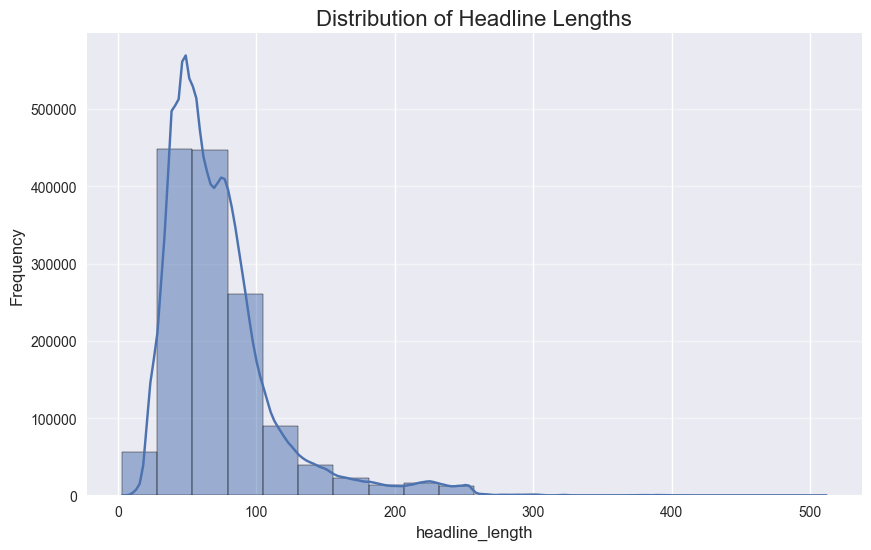

In [9]:
# Calculate headline lengths
df['headline_length'] = df['headline'].str.len()

# Basic statistics
headline_stats = df['headline_length'].describe()
print("Headline Length Statistics:")
print(headline_stats)

# Visualize with PlotHelper
helper = PlotHelper()
helper.histogram(df, column='headline_length', bins=20, title='Distribution of Headline Lengths')

Number of Articles per Publisher:
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
                      ...  
MoneyGeek                 1
muathe                    1
Robert Morris             1
LeftCoastHedgie           1
Jeremie Capron            1
Name: count, Length: 1034, dtype: int64


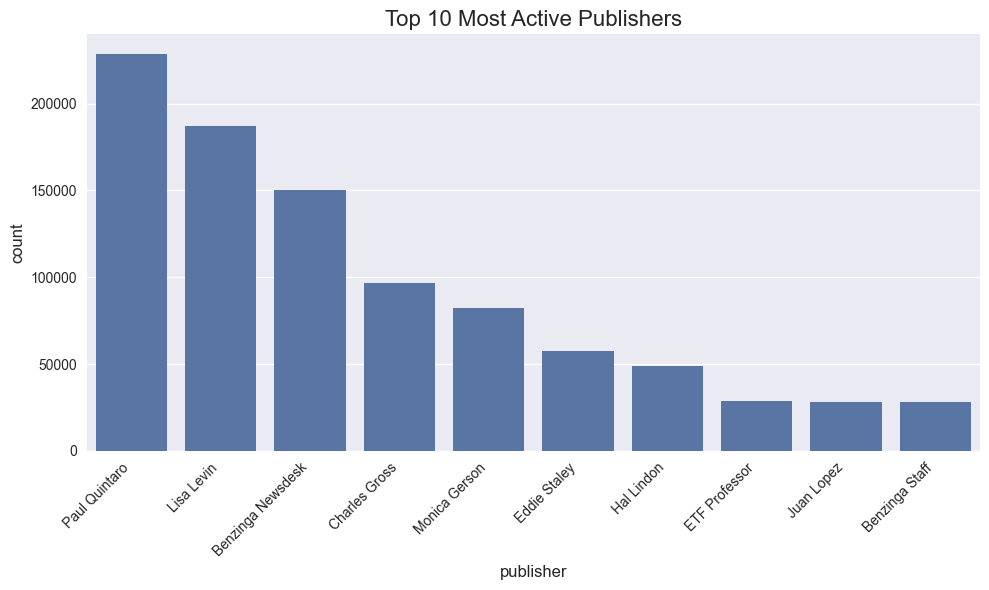

In [15]:
# Count articles per publisher
publisher_counts = df['publisher'].value_counts()
print("Number of Articles per Publisher:")
print(publisher_counts)

# Visualize top 10 with PlotHelper
top_publishers = publisher_counts.head(10).reset_index()
top_publishers.columns = ['publisher', 'count']
helper.bar(top_publishers, x='publisher', y='count', title='Top 10 Most Active Publishers')

Daily Article Counts:
        date  count
0 2009-02-14      1
1 2009-04-27      2
2 2009-04-29      1
3 2009-05-22      1
4 2009-05-27      6


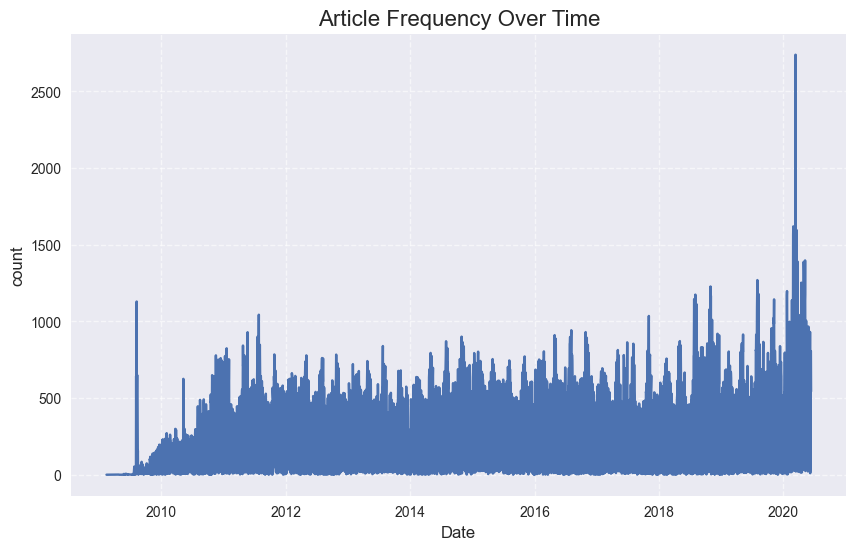

Articles by Day of Week:
         day   count
0   Thursday  302619
1  Wednesday  300922
2    Tuesday  296505
3     Monday  265139
4     Friday  217918
5     Sunday   16466
6   Saturday    7759


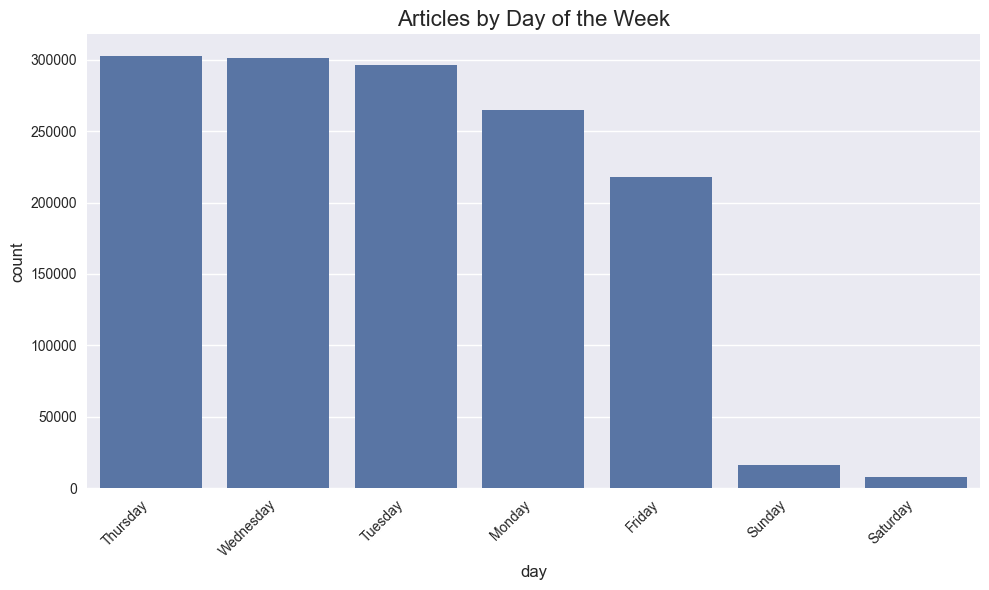

In [21]:
# Ensure 'date' is datetime (since it's the index now)
df.index = pd.to_datetime(df.index, errors='coerce')

# Group by date and count articles
daily_counts = df.groupby(df.index.date).size().reset_index(name='count')
daily_counts.rename(columns={'index': 'date'}, inplace=True)
daily_counts['date'] = pd.to_datetime(daily_counts['date'])
print("Daily Article Counts:")
print(daily_counts.head())

# Plot trends over time with PlotHelper
helper.line_plot(daily_counts, x='date', y='count', title='Article Frequency Over Time')

# Analyze by day of week
df['day_of_week'] = df.index.day_name()
weekly_counts = df['day_of_week'].value_counts().reset_index()
weekly_counts.columns = ['day', 'count']
print("Articles by Day of Week:")
print(weekly_counts)

# Visualize days with PlotHelper
helper.bar(weekly_counts, x='day', y='count', title='Articles by Day of the Week')

Text Analysis(Topic Modeling):

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
import re
from itertools import chain

# Example:
# data = {'headline': [
#     "Stock XYZ receives FDA approval for new drug, share price soars.",
#     "Analyst sets new price target for ABC after strong earnings report.",
#     "Tech merger talks between Company 1 and Company 2 continue.",
#     "FDA approval process is nearing completion for another biotech stock.",
#     "Price target raised for XYZ following excellent earnings report."
# ]}
# df = pd.DataFrame(data)

# --- NLTK Downloads (Run this cell once) ---
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# --- 1. Preprocessing Function ---
def preprocess_text(text):
    """Clean, tokenize, remove stop words, and lemmatize text."""
    text = re.sub(r'[^\w\s]', '', text.lower())  # Remove punctuation and lowercase
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return tokens # Return list of tokens instead of a single string for easier counting

# Apply preprocessing to headlines and store as a list of tokens
df['processed_tokens'] = df['headline'].apply(preprocess_text)

# --- 2. Extract Common Keywords (Unigrams/Bigrams) ---
# Flatten the list of all tokens
all_tokens = list(chain.from_iterable(df['processed_tokens']))

# Get Unigrams (single words)
unigram_counts = Counter(all_tokens)
print("## Top 20 Common Unigrams:")
for word, count in unigram_counts.most_common(20):
    print(f"{word}: {count}")

# Get Bigrams (two-word phrases)
bigram_tokens = list(nltk.ngrams(all_tokens, 2))
bigram_counts = Counter(bigram_tokens)
print("\n## Top 10 Common Bigrams:")
for bigram, count in bigram_counts.most_common(10):
    print(f"{' '.join(bigram)}: {count}")

# --- 3. Identify Significant Events/Phrases ---
significant_phrases = ['fda approval', 'price target', 'earnings report', 'merger', 'acquisition', 'stock split', 'dividend']
phrase_counts = Counter()

# Note: We use the original headline (lowercased) for this simple string search
# to ensure we capture the whole phrase before tokenization potentially breaks it up.
for headline in df['headline'].str.lower():
    for phrase in significant_phrases:
        if phrase in headline:
            phrase_counts[phrase] += 1

print("\n## Counts of Significant Phrases:")
for phrase, count in phrase_counts.most_common():
    print(f"**{phrase}**: {count}")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


KeyboardInterrupt: 

Time Series Analysis:

How does the publication frequency vary over time? Are there spikes in article publications related to specific market events?
Analysis of publishing times might reveal if there’s a specific time when most news is released, which could be crucial for traders and automated trading systems.


Daily Publication Frequency:
date
2009-02-14 00:00:00+00:00    1
2009-02-15 00:00:00+00:00    0
2009-02-16 00:00:00+00:00    0
2009-02-17 00:00:00+00:00    0
2009-02-18 00:00:00+00:00    0
2009-02-19 00:00:00+00:00    0
2009-02-20 00:00:00+00:00    0
2009-02-21 00:00:00+00:00    0
2009-02-22 00:00:00+00:00    0
2009-02-23 00:00:00+00:00    0
Freq: D, dtype: int64


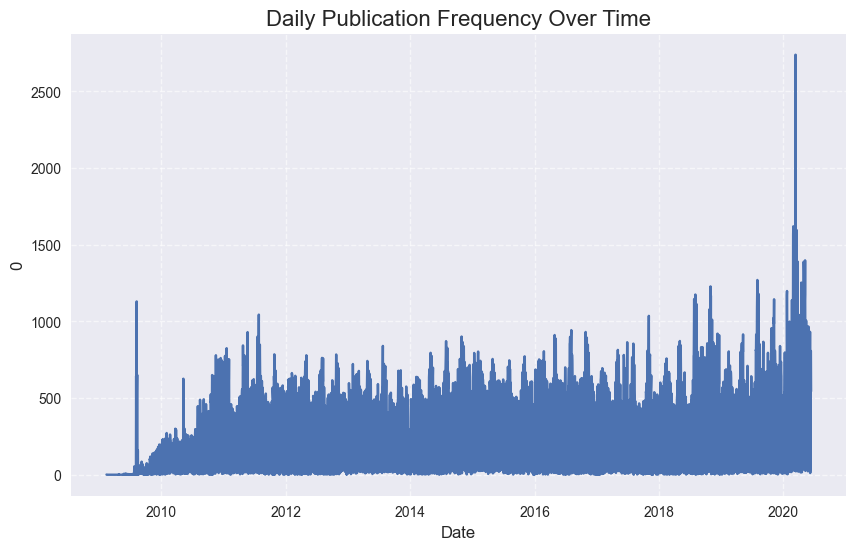


Potential Spike Days (above 2 std from 7-day rolling mean):
date
2009-04-27 00:00:00+00:00      2
2009-05-22 00:00:00+00:00      1
2009-05-27 00:00:00+00:00      6
2009-07-07 00:00:00+00:00      2
2009-07-21 00:00:00+00:00      7
2009-07-27 00:00:00+00:00     54
2009-08-04 00:00:00+00:00      7
2009-08-06 00:00:00+00:00     49
2009-08-07 00:00:00+00:00    644
2009-08-25 00:00:00+00:00     38
dtype: int64

Publication Counts by Hour of Day:
hour
0         131
1          82
2          48
3          27
4     1351408
5          14
6          57
7          93
8        1469
9        1829
10       2476
11       5033
12       5527
13       5965
14       7669
15       5701
16       5732
17       2710
18       2075
19       1612
20       3939
21       2800
22        704
23        227
dtype: int64


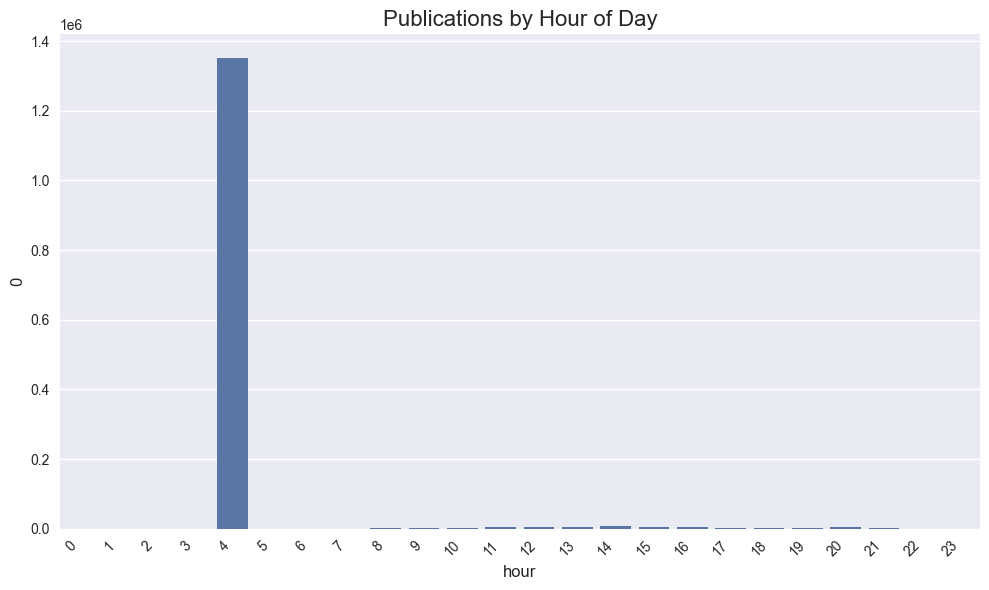

In [11]:

# 1. Publication Frequency Over Time
# Resample to daily frequency and count articles
daily_freq = df.resample('D').size()
print("Daily Publication Frequency:")
print(daily_freq.head(10))

# Plot daily frequency
helper.line_plot(daily_freq.reset_index(), x='date', y=0, title='Daily Publication Frequency Over Time')

# 2. Identify Spikes (e.g., days with significantly higher publications)
# Calculate rolling mean and std for anomaly detection
rolling_mean = daily_freq.rolling(window=7).mean()
rolling_std = daily_freq.rolling(window=7).std()
threshold = rolling_mean + 2 * rolling_std
spikes = daily_freq[daily_freq > threshold]
print("\nPotential Spike Days (above 2 std from 7-day rolling mean):")
print(spikes.head(10))

# Note: To relate to market events, you would need external data (e.g., stock prices, earnings dates).
# For now, this identifies statistical spikes. Manually check headlines on spike dates for events.

# 3. Analysis of Publishing Times
# Extract hour of day from index
df['hour'] = df.index.hour
hourly_counts = df.groupby('hour').size()
print("\nPublication Counts by Hour of Day:")
print(hourly_counts)

# Plot hourly distribution
helper.bar(hourly_counts.reset_index(), x='hour', y=0, title='Publications by Hour of Day')


Publisher Analysis:

- Which publishers contribute most to the news feed? Is there a difference in the type of news they report?

- If email addresses are used as publisher names, identify unique domains to see if certain organizations contribute more frequently.


Top 10 Publishers by Number of Articles:
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64


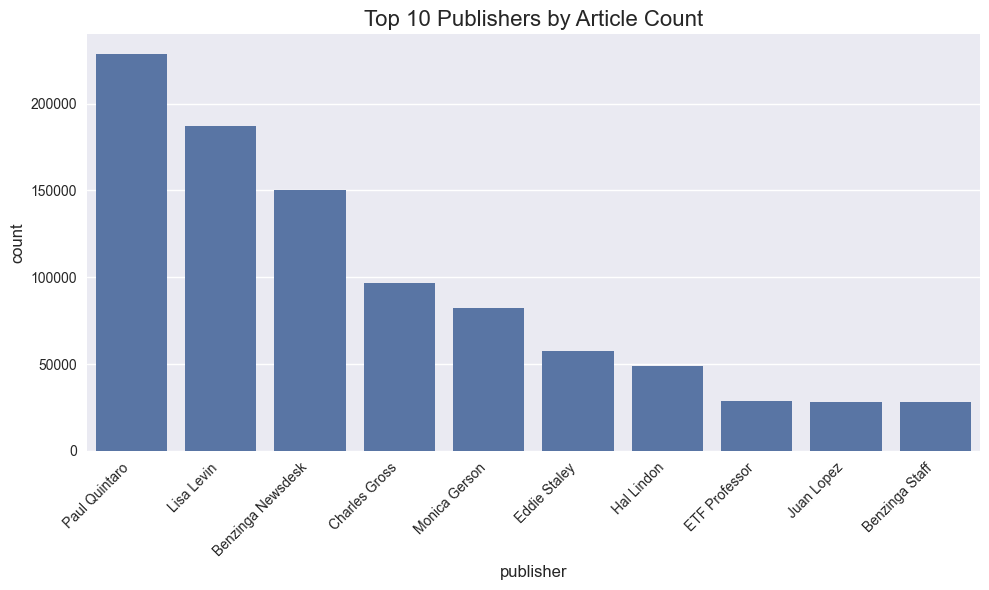


Common words for Paul Quintaro:
est: 82574
eps: 57024
reports: 55267
sales: 31448
from: 28270
shares: 22836
sees: 20735
announces: 20379
inc: 19731
revenue: 14699


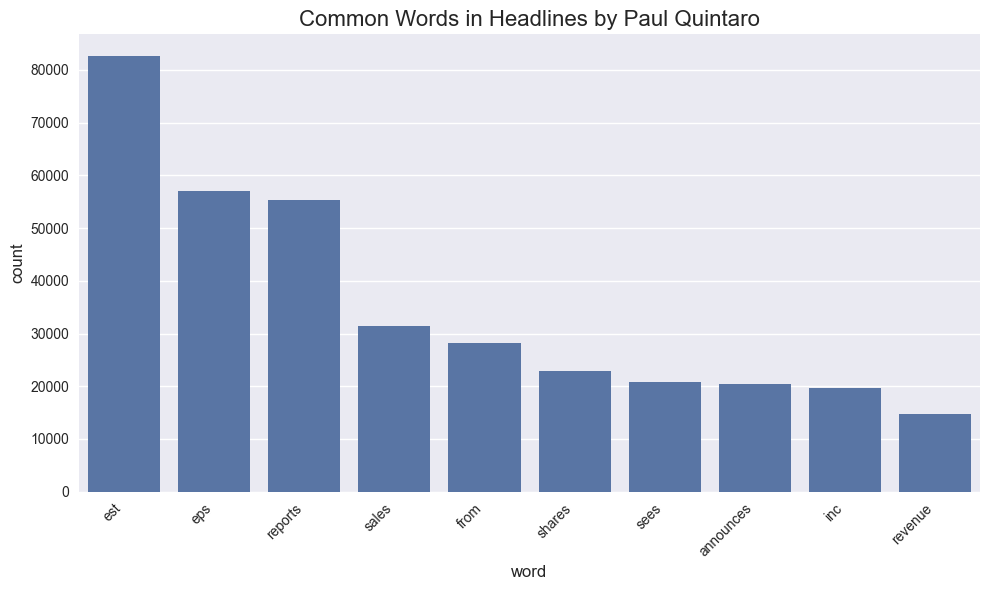


Common words for Lisa Levin:
stocks: 68373
market: 50876
mid: 42690
moving: 32324
session: 32324
top: 31272
biggest: 29090
benzinga: 28547
day: 28211
week: 25340


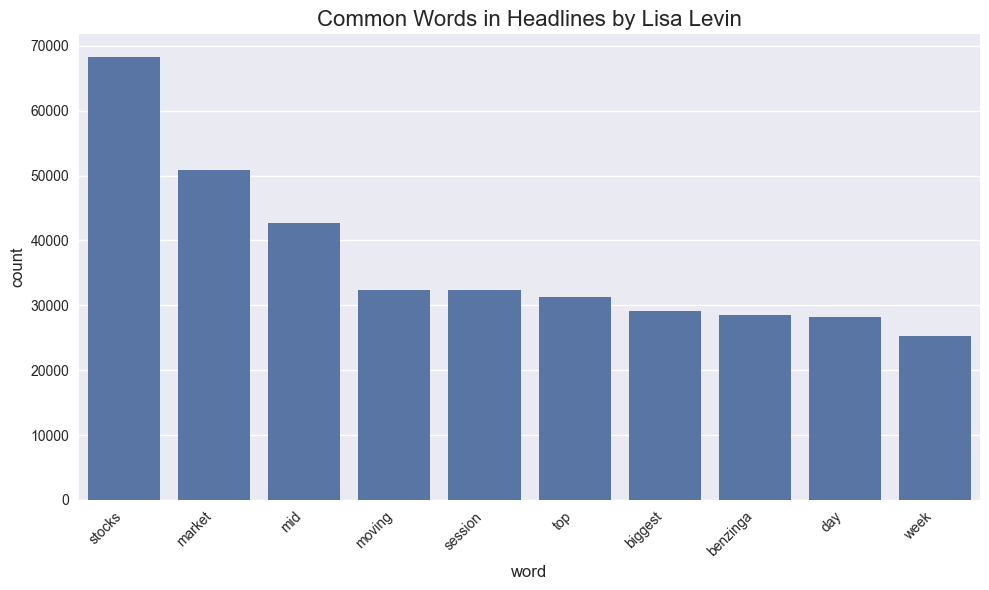


Common words for Benzinga Newsdesk:
shares: 42673
trading: 38841
estimate: 29404
stocks: 27844
eps: 27425
sales: 27385
down: 24363
from: 22713
companies: 22019
new: 21465


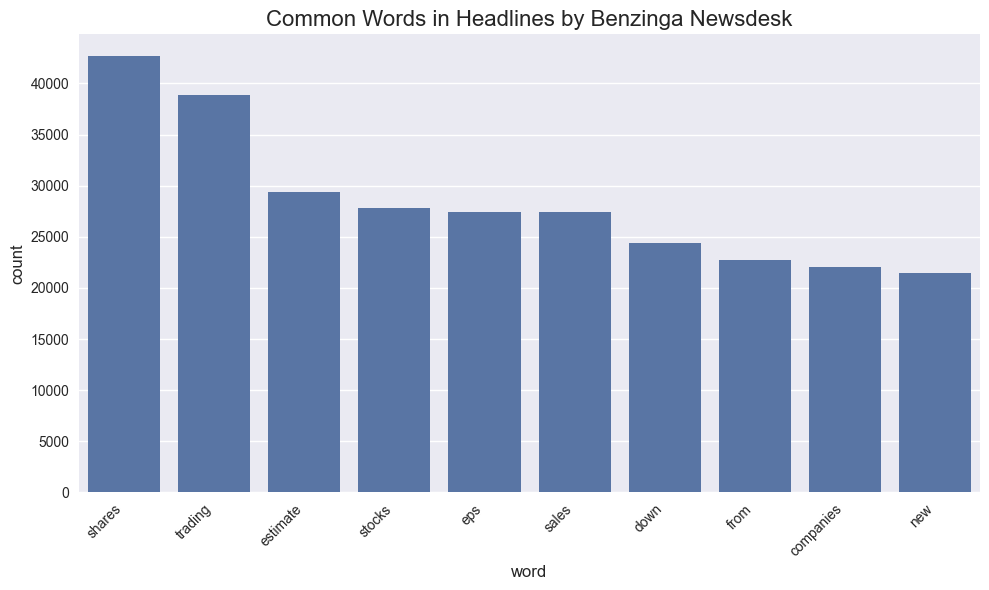


Unique domains from email publishers:
publisher
benzinga              7937
gmail                  139
andyswan                 5
investdiva               2
tothetick                2
eosdetroit               1
forextraininggroup       1
stockmetrix              1
Name: count, dtype: int64


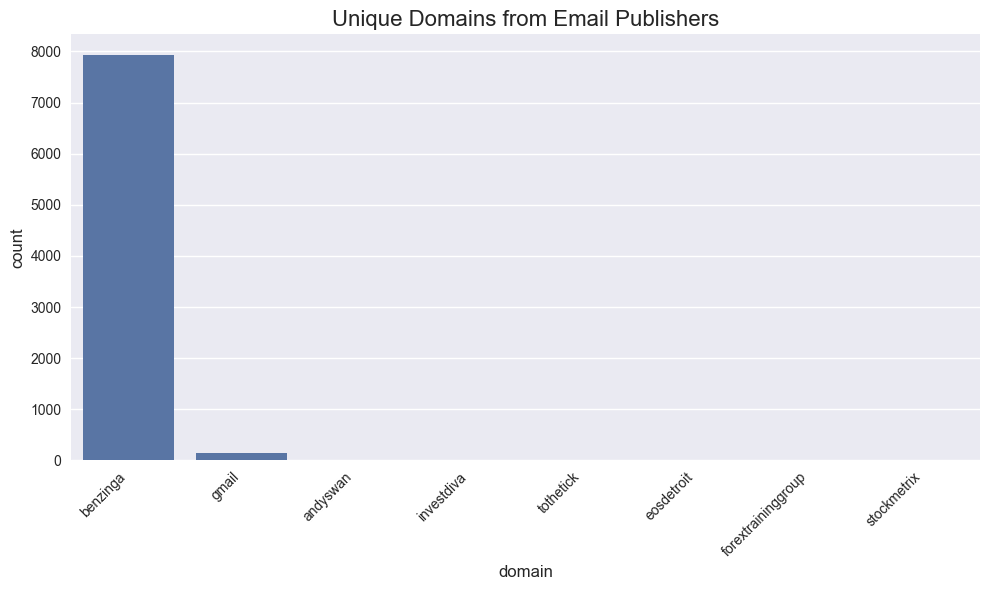

In [25]:
# Publisher Analysis

# 1. Which publishers contribute most to the news feed?
publisher_counts = df['publisher'].value_counts()
print("Top 10 Publishers by Number of Articles:")
print(publisher_counts.head(10))

# Visualize top 10 publishers
top_10_publishers = publisher_counts.head(10).reset_index()
top_10_publishers.columns = ['publisher', 'count']
helper.bar(top_10_publishers, x='publisher', y='count', title='Top 10 Publishers by Article Count')

# To see if there's a difference in the type of news they report,
# let's look at the most common words in headlines for the top 3 publishers
from collections import Counter
import re

def get_common_words(headlines, top_n=10):
    all_words = []
    for headline in headlines:
        words = re.findall(r'\b\w+\b', headline.lower())
        all_words.extend(words)
    # Remove common stop words (basic list)
    stop_words = set(['the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'is', 'are', 'was', 'were', 'be', 'been', 'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could', 'should', 'may', 'might', 'must', 'can', 'this', 'that', 'these', 'those'])
    filtered_words = [word for word in all_words if word not in stop_words and len(word) > 2]
    return Counter(filtered_words).most_common(top_n)

top_publishers = publisher_counts.head(3).index
for publisher in top_publishers:
    headlines = df[df['publisher'] == publisher]['headline']
    common_words = get_common_words(headlines)
    print(f"\nCommon words for {publisher}:")
    for word, count in common_words:
        print(f"{word}: {count}")
    
    # Visualize common words for this publisher
    words_df = pd.DataFrame(common_words, columns=['word', 'count'])
    helper.bar(words_df, x='word', y='count', title=f'Common Words in Headlines by {publisher}')

# 2. If email addresses are used as publisher names, identify unique domains
email_publishers = df['publisher'].str.contains('@', na=False)
if email_publishers.any():
    domains = df[email_publishers]['publisher'].str.split('@').str[1].str.split('.').str[0]
    unique_domains = domains.value_counts()
    print("\nUnique domains from email publishers:")
    print(unique_domains)
    
    # Visualize unique domains
    domains_df = unique_domains.reset_index()
    domains_df.columns = ['domain', 'count']
    helper.bar(domains_df, x='domain', y='count', title='Unique Domains from Email Publishers')
else:
    print("\nNo email addresses found in publisher names.")
    